In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# import nltk
# from nltk.tokenize import word_tokenize

# # Download the necessary NLTK data (if needed)
# nltk.download('punkt')

# def nltk_tokenizer(text):
#     return word_tokenize(text)

In [9]:
# Load data
data = pd.read_csv('/kaggle/input/train-data-final/training_data.csv')
# data_test = pd.read_csv('/kaggle/input/nlp-dataset/SarcasmHeadlinesDataset_test.csv')

In [10]:
data =data[(data['label']==0) | (data['label']==1)]
data['label'] = data['label'].astype(int)

In [12]:
data.head()

,ID,article_link,text,label
0,4724,https://www.huffingtonpost.com/entry/trump-rea...,"how trump really feels about queer people, exp...",0
1,26559,https://www.huffingtonpost.com/entry/egyptian-...,egyptian death sentence for soccer fans puts p...,0
2,24613,https://www.theonion.com/stripper-failing-scho...,stripper failing school she's working self thr...,1
3,9048,https://www.huffingtonpost.com/entry/ken-paxto...,texas attorney general ken paxton indicted,0
4,69,https://www.huffingtonpost.com/entry/debbie-di...,congresswoman fights for gun control because s...,0


In [13]:
# data_test = data_test[['ID','TEXT']].dropna()

In [14]:
# data_test.reset_index(drop=True)

In [15]:
data = data[['text', 'label']].dropna()

In [16]:
data.reset_index(drop=True)

,text,label
0,"how trump really feels about queer people, exp...",0
1,egyptian death sentence for soccer fans puts p...,0
2,stripper failing school she's working self thr...,1
3,texas attorney general ken paxton indicted,0
4,congresswoman fights for gun control because s...,0
...,...,...
22890,turnout lower than expected for gala central a...,1
22891,retreating clinton campaign torches iowa town ...,1
22892,national weather service to give hurricanes fu...,1
22893,christ returns for some of his old things,1


In [17]:
# Prepare dataset
class SarcasmDataset(Dataset):
    def __init__(self, ids, texts, labels, tokenizer, vocab, max_len):
        self.texts = texts  
        self.labels = labels
        self.ids = ids
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if(self.labels is not None):
            label = self.labels[idx]
        else:
            ids = self.ids[idx]
        tokens = self.tokenizer(text)
        tokens = [self.vocab[token] for token in tokens]
        if len(tokens) < self.max_len:
            tokens += [self.vocab['<pad>']] * (self.max_len - len(tokens))
        if(self.labels is not None):
            return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.float)
        else:
            return torch.tensor(ids, dtype=torch.long), torch.tensor(tokens, dtype=torch.int)

In [18]:
# Tokenizer and Vocabulary
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)
vocab = build_vocab_from_iterator(yield_tokens(data['text']), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

In [19]:
max_len = 100

In [20]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(data['text'], data['label'], test_size=0.3, random_state=42)
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
train_dataset = SarcasmDataset(None, train_texts, train_labels, tokenizer, vocab, max_len)
val_dataset = SarcasmDataset(None, val_texts, val_labels, tokenizer, vocab, max_len)

In [21]:
# test_texts = data_test['TEXT']
# test_ids = data_test['ID']
# test_dataset = SarcasmDataset(test_ids,test_texts, None, tokenizer, vocab, max_len)

In [22]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [23]:
# Model
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dense_outputs = self.fc(hidden)
        outputs = self.act(dense_outputs)
        return outputs

In [24]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(len(vocab), 100, 256, 1, 2, True, 0.5).to(device)

In [25]:
# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Training Function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
#     i = 0
    labels_list = []
    predictions_list = []
    for texts, labels in iterator:
#         if i%100 == 0:
#             print(i)
        texts = texts.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#         i += 1
        labels_list.extend(labels.cpu().detach().numpy().tolist())
        predictions_list.extend(predictions.cpu().detach().numpy().tolist())
    return epoch_loss / len(iterator), labels_list, predictions_list

In [27]:
# Evaluation Function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    labels_list = []
    predictions_list = []
    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            labels = labels.to(device)
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
            labels_list.extend(labels.cpu().detach().numpy().tolist())
            predictions_list.extend(predictions.cpu().detach().numpy().tolist())
    return epoch_loss / len(iterator), labels_list, predictions_list

In [28]:
# Training loop
num_epochs = 15
train_loss =[]
valid_loss =[]
for epoch in range(num_epochs):
    loss_train, pred_labels_list, pred_predictions_list = train(model, train_loader, optimizer, criterion)
    train_loss.append(loss_train)
    loss_val, val_labels_list, val_predictions_list = evaluate(model, val_loader, criterion)
    valid_loss.append(loss_val)
    print(f'Epoch: {epoch+1}, Train Loss: {loss_train:.4f}, Val. Loss: {loss_val:.4f}')

Epoch: 1, Train Loss: 0.4930, Val. Loss: 0.4813
Epoch: 2, Train Loss: 0.3393, Val. Loss: 0.4559
Epoch: 3, Train Loss: 0.2202, Val. Loss: 0.4967
Epoch: 4, Train Loss: 0.1297, Val. Loss: 0.6471
Epoch: 5, Train Loss: 0.0838, Val. Loss: 0.6743
Epoch: 6, Train Loss: 0.0571, Val. Loss: 0.8188
Epoch: 7, Train Loss: 0.0342, Val. Loss: 0.8206
Epoch: 8, Train Loss: 0.0235, Val. Loss: 0.9476
Epoch: 9, Train Loss: 0.0180, Val. Loss: 0.8663
Epoch: 10, Train Loss: 0.0143, Val. Loss: 0.9947
Epoch: 11, Train Loss: 0.0134, Val. Loss: 0.9477
Epoch: 12, Train Loss: 0.0092, Val. Loss: 1.0423
Epoch: 13, Train Loss: 0.0050, Val. Loss: 1.1106
Epoch: 14, Train Loss: 0.0117, Val. Loss: 0.9889
Epoch: 15, Train Loss: 0.0081, Val. Loss: 1.0350


In [ ]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_loss')
plt.show()

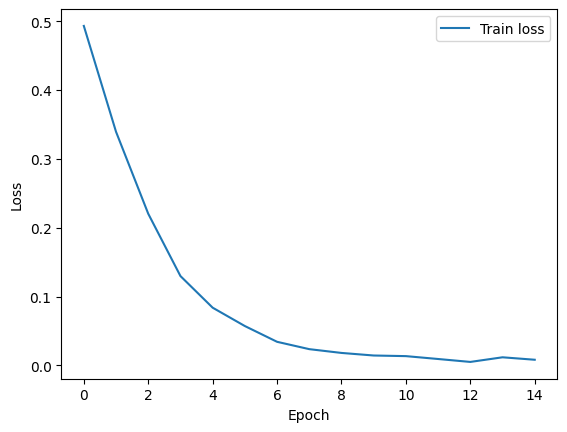

In [31]:
plt.plot(train_loss, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_loss.png')
plt.show()

In [42]:
df = pd.DataFrame(train_loss)

# Saving DataFrame to a CSV file
df.to_csv('loss_data.csv', index=False)

In [ ]:
plt.plot(valid_loss, label='Valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('valid_loss.png')
plt.savefig('n_loss')
plt.show()

In [40]:
model_path = "/kaggle/working/lstm_model_15epochs.pth"
torch.save(model.state_dict(), model_path)

In [39]:
def evaluate_metrics (labels, predictions, scores):
    
    import matplotlib.pyplot as plt

    print(metrics.classification_report(labels, predictions))

    cm = metrics.confusion_matrix(labels, predictions)
    print("Confusion Matrix =")
    print(cm)
    cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot()
    # plt.show()
    plt.savefig('confusion_matrix.png')

    # Calculate ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

    # Calculate AUROC score
    auroc_score = metrics.roc_auc_score(labels, scores)

    # Print AUROC score
    print(f"AUROC Score = {auroc_score}")

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_plot.png')
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8417
           1       1.00      1.00      1.00      7609

    accuracy                           1.00     16026
   macro avg       1.00      1.00      1.00     16026
weighted avg       1.00      1.00      1.00     16026

Confusion Matrix =
[[8394   23]
 [  22 7587]]
AUROC Score = 0.99989647115519


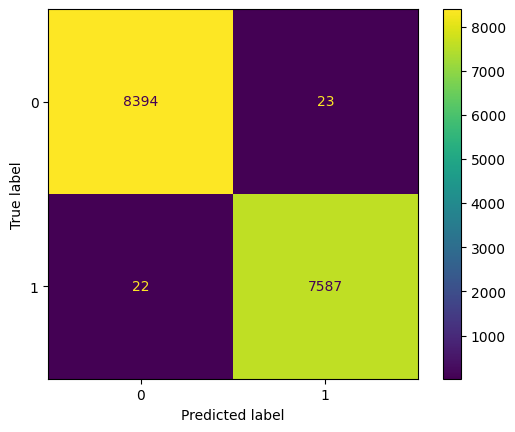

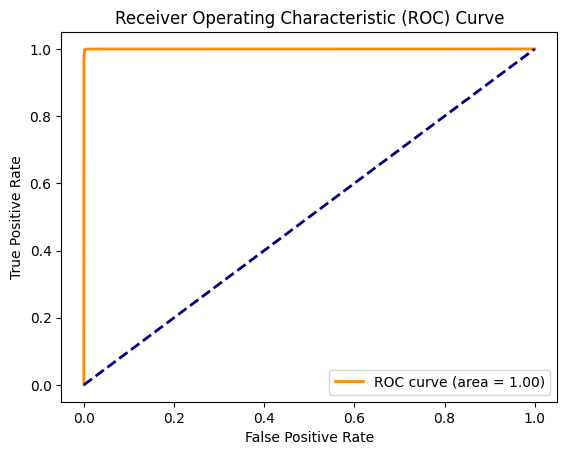

In [40]:
scores = pred_predictions_list
predictions = np.array(pred_predictions_list) >= 0.5
labels = np.array(pred_labels_list).astype(int)
evaluate_metrics (labels, predictions, scores)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3573
           1       0.84      0.80      0.82      3296

    accuracy                           0.83      6869
   macro avg       0.83      0.83      0.83      6869
weighted avg       0.83      0.83      0.83      6869

Confusion Matrix =
[[3073  500]
 [ 673 2623]]
AUROC Score = 0.9109574675492299


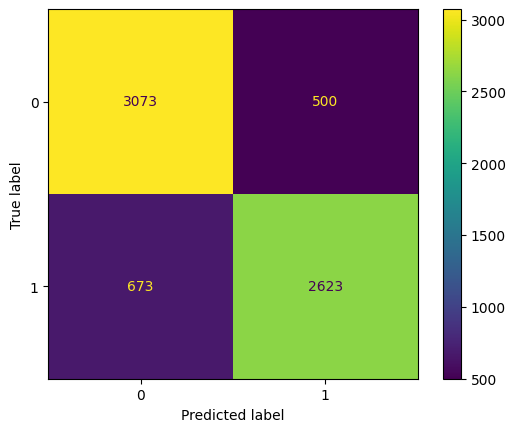

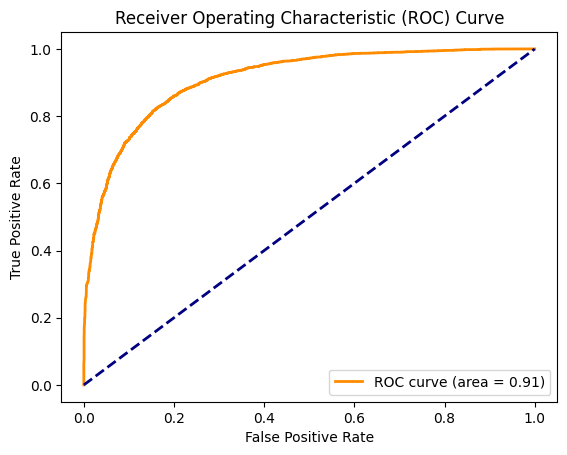

In [41]:
scores = val_predictions_list
predictions = np.array(val_predictions_list) >= 0.5
labels = np.array(val_labels_list).astype(int)
evaluate_metrics (labels, predictions, scores)